In [2]:
#loading the training data

import pandas as pd

df = pd.read_csv('C:/Users/Raghul/Desktop/Mood/dataset/training/train_lyrics_1000.csv')

df.head()

,file,artist,title,lyrics,genre,mood,year
0,TRAAAAW128F429D538.h5,Casual,I Didn't Mean To,Verse One:\n\nAlright I might\nHave had a litt...,Hip Hop/Rap,sad,1994
1,TRAAAEF128F4273421.h5,Adam Ant,Something Girls,Adam Ant/Marco Pirroni\nEvery girl is a someth...,Rock,happy,1982
2,TRAAAFD128F92F423A.h5,Gob,Face the Ashes,"I've just erased it's been a while, I've got a...",Rock,sad,2007
3,TRAABJV128F1460C49.h5,Lionel Richie,Tonight Will Be Alright,Little darling \nWhere you've been so long \nI...,R&B,happy,1986
4,TRAABLR128F423B7E3.h5,Blue Rodeo,Floating,"Lead Vocal by Greg\n\nWell, these late night c...",Rock,sad,1987


In [3]:
#setting the values of the mood label to 0 and 1

from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np

X_train = df['lyrics'].values 

y_train = df['mood'].values

print('before: %s ...' %y_train[:5])

le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print('after: %s ...' %y_train[:5])

before: ['sad' 'happy' 'sad' 'happy' 'sad'] ...
after: [1 0 1 0 1] ...


In [4]:

# Save object to disk

import pickle

pickle_out = open('C:/Users/Raghul/Desktop/Mood/lyrics_label_encoder_py.pkl', 'wb')
pickle.dump(le, pickle_out)
pickle_out.close()

In [5]:
# Porter Stemmer

import nltk
import string
import re

porter_stemmer = nltk.stem.porter.PorterStemmer()
# Porterstemmer tokenizer basicallaplits sentences into words and apploes the porter stemming alogrithm to each of the word 
# obtained. In th process, the words contaning only punctuation are removed and list of words are returned. 

def porter_tokenizer(text, stemmer=porter_stemmer):
    lower_txt = text.lower()
    tokens = nltk.wordpunct_tokenize(lower_txt)
    stems = [porter_stemmer.stem(t) for t in tokens]
    no_punct = [s for s in stems if re.match('^[a-zA-Z]+$', s) is not None]
    return no_punct

In [6]:
# Test Run of Porter Stemmer tokenizer
porter_tokenizer("Hi !!! - how are-  you.. ")

['hi', 'how', 'are', 'you']

In [7]:
# I have a few words on a text file which are called stop words, which dont contribute towards the classification of our songs and 
#and that which can be removed

with open('C:/Users/Raghul/Desktop/Mood/stopwords_eng.txt', 'r') as infile:
    stop_words = infile.read().splitlines()
print('stop words %s ...' %stop_words[:5])

stop words ['i', 'me', 'my', 'myself', 'we'] ...


In [9]:

# Count Vectorizer
#Convert a collection of text documents to a matrix of token counts
#This implementation produces a sparse representation of the counts

from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(1,1)
    )

In [10]:
#Testing the removal of stop words

vocab = ["123 1 Hi\n I am not going to school today"]

vec = vec.fit(vocab)


print('TEST:')
print('Vocabulary: %s' %vec.get_feature_names())

TEST:
Vocabulary: ['go', 'hi', 'school', 'today']


In [11]:
#Fitting Lyrics
vec = vec.fit(X_train.ravel())

In [12]:
print('Vocabulary size: %s' %len(vec.get_feature_names()))

Vocabulary size: 8550


In [13]:
#test 2 (N-grams = 2)
#The lower and upper boundary of the range of n-values for different n-grams to be extracted. 
#All values of n such that min_n <= n <= max_n will be used.

vec = CountVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer,
            ngram_range=(2,2)
    )

vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

vec = vec.fit(vocab)


print('TEST:')
print('Vocabulary: %s' %vec.get_feature_names())


TEST:
Vocabulary: ['like swim', 'swim didn', 'swim swim', 'swimmer like']


In [15]:
#tf idf vectorizer
#Convert a collection of raw documents to a matrix of TF-IDF features.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
            encoding='utf-8',
            decode_error='replace',
            strip_accents='unicode',
            analyzer='word',
            binary=False,
            stop_words=stop_words,
            tokenizer=porter_tokenizer
    )


In [16]:
#Testing
vocab = ["123 1 The\n swimmer likes swimming so he swims. Don't didn`t"]

tfidf = tfidf.fit(vocab)

sentence1 = tfidf.transform([u'The swimmer likes swimming.'])
sentence2 = tfidf.transform(['The\nswimmer \nswims.'])


print('TEST:')
print('Vocabulary: %s' %tfidf.get_feature_names())
print('Sentence 1: %s' %sentence1.toarray())
print('Sentence 2: %s' %sentence2.toarray())


TEST:
Vocabulary: ['didn', 'like', 'swim', 'swimmer']
Sentence 1: [[ 0.          0.57735027  0.57735027  0.57735027]]
Sentence 2: [[ 0.          0.          0.70710678  0.70710678]]


In [17]:
#Fitting th Lyrics
tfidf = tfidf.fit(X_train.ravel())

print('Vocabulary size: %s' %len(tfidf.get_feature_names()))

Vocabulary size: 8550


In [18]:
#Model Selection
#Models: Multivariate Bernoulli and Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline

In [19]:
#custome scorer methods to account for positive-negative class labels
from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)

In [20]:
#Grid Search for Countvectorizer and BernoulliNB

from sklearn.grid_search import GridSearchCV
from pprint import pprint

pipeline_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', BernoulliNB())
])

parameters_1 = dict(
    vect__binary=[True],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_1 = GridSearchCV(pipeline_1, 
                           parameters_1, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_1.steps])
print("parameters:")
pprint(parameters_1, depth=2)
grid_search_1.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_1.best_score_)
print("Best parameters set:")
best_parameters_1 = grid_search_1.best_estimator_.get_params()
for param_name in sorted(parameters_1.keys()):
    print("\t%s: %r" % (param_name, best_parameters_1[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [True],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000001CACE506AE8>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\Users\Raghul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  5.5min
C:\Users\Raghul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Raghul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Raghul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Raghul\Anaconda3\

Best score: 0.617
Best parameters set:
	vect__binary: True
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 

In [21]:
#Grid Search for CountVectorizer and MultinomialNB

from sklearn.grid_search import GridSearchCV

pipeline_3 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

parameters_3 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_3 = GridSearchCV(pipeline_3, 
                           parameters_3, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_3.steps])
print("parameters:")
pprint(parameters_3, depth=2)
grid_search_3.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_3.best_score_)
print("Best parameters set:")
best_parameters_3 = grid_search_3.best_estimator_.get_params()
for param_name in sorted(parameters_3.keys()):
    print("\t%s: %r" % (param_name, best_parameters_3[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [False],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000001CACE506AE8>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  5.2min
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 12.9min finished


Best score: 0.620
Best parameters set:
	vect__binary: False
	vect__ngram_range: (1, 1)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

In [22]:
#Gridsearch for Tfidf Vectorizer and Multinomial NB

from sklearn.grid_search import GridSearchCV

pipeline_4 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

parameters_4 = dict(
    vect__binary=[False],
    vect__stop_words=[stop_words, None],
    vect__tokenizer=[porter_tokenizer, None],
    vect__ngram_range=[(1,1), (2,2), (3,3)],
)

grid_search_4 = GridSearchCV(pipeline_4, 
                           parameters_4, 
                           n_jobs=1, 
                           verbose=1,
                           scoring=f1_scorer,
                           cv=10
                )


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_4.steps])
print("parameters:")
pprint(parameters_4, depth=2)
grid_search_4.fit(X_train, y_train)
print("Best score: %0.3f" % grid_search_4.best_score_)
print("Best parameters set:")
best_parameters_4 = grid_search_4.best_estimator_.get_params()
for param_name in sorted(parameters_4.keys()):
    print("\t%s: %r" % (param_name, best_parameters_4[param_name]))

Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__binary': [False],
 'vect__ngram_range': [(...), (...), (...)],
 'vect__stop_words': [[...], None],
 'vect__tokenizer': [<function porter_tokenizer at 0x000001CACE506AE8>, None]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits


C:\Users\Raghul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  4.6min
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.2min finished


Best score: 0.335
Best parameters set:
	vect__binary: False
	vect__ngram_range: (2, 2)
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',

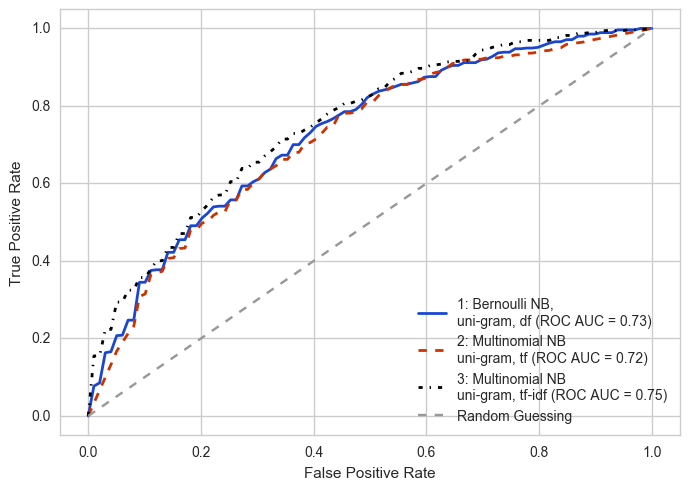

In [23]:
#Plotting thre ROC Curve for three different classifiers used

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import StratifiedKFold
from scipy import interp

sns.set()
sns.set_style("whitegrid")

clf_1 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=True,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', BernoulliNB()),
                 ])

clf_2 = Pipeline([
                  ('vect', CountVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

clf_3 = Pipeline([
                  ('vect', TfidfVectorizer(
                                           binary=False,
                                           stop_words=stop_words,
                                           tokenizer=porter_tokenizer,
                                           ngram_range=(1,1),
                                           )
                 ),
                 ('clf', MultinomialNB()),
                 ])

colors = ['#1947D1', '#CC3300', 'k']
linestyles = ['-', '--', '-.']
classifiers = [clf_1, clf_2, clf_3]

#providing lables for all the classfiers

labels = ['1: Bernoulli NB, \nuni-gram, df', 
          '2: Multinomial NB \nuni-gram, tf',
          '3: Multinomial NB\nuni-gram, tf-idf',
          ]

for clf,col,ls,lab in zip(classifiers, colors, linestyles, labels):
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    cv = StratifiedKFold(y_train, n_folds=10, random_state=123)

    for i, (train, test) in enumerate(cv):
        probas_ = clf.fit(X_train[train], y_train[train]).predict_proba(X_train[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, 
             mean_tpr, 
             color=col, 
             linestyle=ls,
             label='%s (ROC AUC = %0.2f)' % (lab, mean_auc), 
             lw=2
    )

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Guessing')    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('C:/Users/Raghul/Desktop/roc_gridsearch_1.eps', dpi=300)
plt.show()


In [24]:
#Validation is done using the tfidf vectorizer and Multinomail NB as that has been selected has the best classifier among the theee
#ROC AUC curve
final_clf = Pipeline([
                ('vect', TfidfVectorizer(
                                         binary=False,
                                         stop_words=stop_words,
                                         tokenizer=porter_tokenizer,
                                         ngram_range=(1,1),
                                         )
                ),
                ('clf', MultinomialNB(alpha=1.0)),
               ])
final_clf.fit(X_train, y_train)


Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...se_idf=True, vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

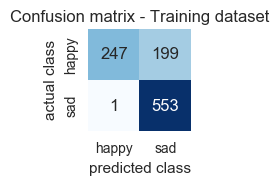

In [25]:
#confusion matrix

import matplotlib as mpl
import numpy as np

cm = metrics.confusion_matrix(y_train, final_clf.predict(X_train))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Training dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('C:/Users/Raghul/Desktop/confmat_training.eps', dpi=300)
plt.show()

In [26]:
df = pd.read_csv('C:/Users/Raghul/Desktop/Mood/dataset/validation/valid_lyrics_200.csv')

X_valid = df['lyrics'].values 
y_valid = df['mood'].values

y_valid = le.transform(y_valid)

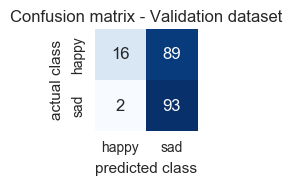

In [27]:
cm = metrics.confusion_matrix(y_valid, final_clf.predict(X_valid))

np.set_printoptions(suppress=True)
mpl.rc("figure", figsize=(4, 2))

hm = sns.heatmap(cm, 
            cbar=False,
            annot=True, 
            square=True,
            fmt='d',
            yticklabels=['happy','sad'],
            xticklabels=['happy','sad'],
            cmap='Blues'
            )
plt.title('Confusion matrix - Validation dataset')
plt.ylabel('actual class')
plt.xlabel('predicted class')
plt.tight_layout()
plt.savefig('C:/Users/Raghul/Desktop/confmat_valid.eps', dpi=300)
plt.show()

In [28]:
# ROC AUC, Accuracy, Precision, Recall, and F1-Score
# Custom scorer methods to account for positive-negative class labels

from sklearn import metrics

# `pos_label` for positive class, since we have sad=1, happy=0

acc_scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
pre_scorer = metrics.make_scorer(metrics.precision_score, greater_is_better=True, pos_label=0)
rec_scorer = metrics.make_scorer(metrics.recall_score, greater_is_better=True, pos_label=0)
f1_scorer = metrics.make_scorer(metrics.f1_score, greater_is_better=True, pos_label=0)
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)

In [29]:
d = {'Data':['Training', 'Validation'],
     'ACC (%)':[],
     'PRE (%)':[],
     'REC (%)':[],
     'F1 (%)':[],
     'ROC AUC (%)':[],
}

In [30]:
d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_train, y_true=y_train))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_train, y_true=y_train))

d['ACC (%)'].append(acc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['PRE (%)'].append(pre_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['REC (%)'].append(rec_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['F1 (%)'].append(f1_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))
d['ROC AUC (%)'].append(auc_scorer(estimator=final_clf, X=X_valid, y_true=y_valid))

In [30]:
df_perform = pd.DataFrame(d)
df_perform = df_perform[['ACC (%)', 'PRE (%)', 'REC (%)', 'F1 (%)', 'ROC AUC (%)']]
df_perform.index=(['Training', 'Validation'])
df_perform = df_perform*100
df_perform = np.round(df_perform, decimals=2)
df_perform

,ACC (%),PRE (%),REC (%),F1 (%),ROC AUC (%)
Training,80.0,99.60,55.38,71.18,77.60
Validation,54.5,88.89,15.24,26.02,56.57


In [31]:
#exporting performance metrics to a csv file
df_perform.to_csv('C:/Users/Raghul/Desktop/NBclf_performance.csv', index_label=False)